#  Analysis of concurrent user sessions 

The goal of this notebook is to identify the maximum number of concurrent users, and see the trend during a day

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

#### Read csv and parse dates columns to datetime objects

In [2]:
df = pd.read_csv('Documentos 201704.csv', encoding='utf-8')
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %H:%M')
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%m/%d/%Y %H:%M')

# Filtering data of April/10 ... 7 am - 4 pm
df = df[(df['Timestamp'] >= '2017-04-10 07:00:00') & (df['Timestamp'] <= '2017-04-10 16:00:00')].sort_values(by=['Timestamp'])

##### Generating time intervals of 1 min from 7 am - 4 pm

In [3]:
interval_length = 1
times = [datetime.datetime(2017, 4, 10, 7, 0, 0) + datetime.timedelta(minutes=interval_length*x) for x in range(9 * 60//interval_length + 1)]
times[0] = datetime.datetime(2017, 4, 10, 6, 59, 0)

time_intervals = []
for i in range(len(times) - 1):
    start, end = times[i], times[i+1]
    time_intervals.append({'start': start, 'end': end})


In [4]:
usernames = df['Username'].unique().tolist()
USER_SESSION_TTL = 30

print('Num of users: ', len(usernames))

Num of users:  786


#### Script to generate session buckets and calculate num of sessions by time interval

In [5]:
intervals_session_count_list = [0 for i in range(len(times) - 1)]
session_buckets = []

for user in usernames:        
    user_data = df[df['Username'] == user].sort_values(by=['Timestamp']) 
    prev_timestamp = None

    for index, doc in user_data.iterrows():
        if prev_timestamp is None:
            prev_timestamp = doc['Timestamp']
            session_buckets.append([doc])
        else:
            difference = doc['Timestamp'] - prev_timestamp
            difference_in_min = int(divmod(difference.total_seconds(), 60)[0])

            if difference_in_min > USER_SESSION_TTL:
                # Add new session bucket
                session_buckets.append([doc])
            else:
                # Add doc to the last session bucket
                session_buckets[-1].append(doc)

            prev_timestamp = doc['Timestamp']
            

for i in range(len(times) - 1):
    start, end = times[i], times[i+1]
    # Indentify what sessions are inside the interval of the iteration
    for session in session_buckets:
        session_start = session[0]['Timestamp']        
        if len(session) > 1:
            session_end = session[-1]['Timestamp']
            if (session_start > start and session_start <= end) or (session_end > start and session_end <= end) or (session_start < start and session_end > end):
                intervals_session_count_list[i] += 1
        else:
            if session_start >= start and session_start <= end:
                intervals_session_count_list[i] += 1

Now with the information generated we can find the peak

In [6]:
max_sessions = max(intervals_session_count_list)
peak_interval = time_intervals[intervals_session_count_list.index(max_sessions)]
peak_interval

{'start': datetime.datetime(2017, 4, 10, 11, 19),
 'end': datetime.datetime(2017, 4, 10, 11, 20)}

In [16]:
print('Number of sessions in the peak: ', max_sessions)

Number of sessions in the peak:  81


##### The maximum number of concurrent sessions was in the interval of 11:19 am - 11:20 am, with a total of 81  sessions

In [8]:
time_intervals_str = []
for interval in time_intervals:
    time_intervals_str.append(str(interval['start'])[11:] +' - '+ str(interval['end'])[11:])

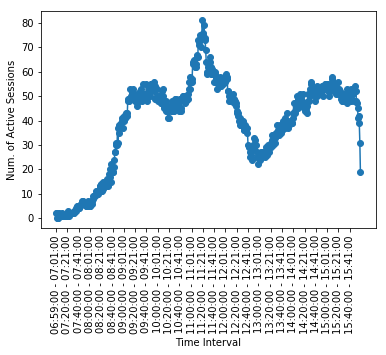

In [9]:
plt.xlabel('Time Interval')
x = [i for i in range(len(time_intervals_str))]
plt.xticks(np.arange(min(x), max(x)+1, 20.0), rotation='vertical')
plt.ylabel('Num. of Active Sessions')
plt.plot(time_intervals_str, intervals_session_count_list, '-o')
plt.show()

- Here we visualize the active sessions throughout the day. We can crop the data and keep a time interval close to the peak, in order to have an easier way to analyze the peak.
- From this plot we can conclude that users have a trend of work in the platform during the morning and close to the launch break (where we see the peak). We can identify launch break with the local minimum between 12:00 and 14:00
- Also the increment on users in the platform during the afternoon is slower, this is expected.

### Crop data to analyze increment in sessions during the morning

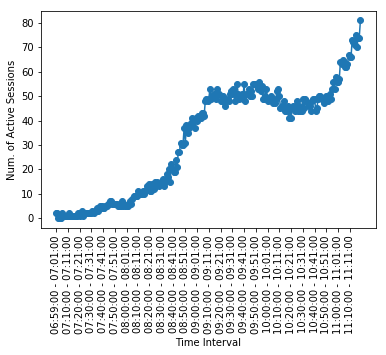

In [11]:
# Generating plot from start to the peak

limit = intervals_session_count_list.index(max(intervals_session_count_list))  # index of the peak

trimmed_x = time_intervals_str[:limit + 1]
trimmed_y = intervals_session_count_list[:limit + 1]

plt.xlabel('Time Interval')
x = [i for i in range(len(trimmed_x))]
plt.xticks(np.arange(min(x), max(x)+1, 10.0), rotation='vertical')

plt.ylabel('Num. of Active Sessions')
plt.plot(trimmed_x, trimmed_y, '-o')
plt.show()

- Now with the crop data we can focus in how the number of users is incrementing during the day until reaching the peak of load in the platform.
- An important question to answer is "how fast users are connecting to the platform? How many hours or minutes took to reach the peak number of concurrent sessions?". For that we are interested in the rate of change of the graph
- Note that the graph is steepest close to 8:50, also at 11:00

### Calculate an estimate for the rate of users connecting to the system

In [23]:
def rate_of_change(start_index, end_index):
    sessions_up_to_peak = intervals_session_count_list[start_index:end_index+1]
    deltas = []

    for i in range(len(sessions_up_to_peak) - 1):
        x1, x2 = sessions_up_to_peak[i], sessions_up_to_peak[i+1]
        delta = x2-x1
        deltas.append(delta)

    return sum(deltas)/len(deltas)

In [24]:
start_index = 0
peak_index = intervals_session_count_list.index(max_sessions)
rate_of_change(start_index, peak_index)

0.305019305019305

- The estimation resulted of: 0.31 sessions/min
- A very slow rate, with this number we can expect users connecting with a rate of: ~ 1 session every 3.3 minutes

### Analyzing rate of change in the interval where the graph is steeper

- The graph is steepest in the interval from to 8:40 - 9:20, also at 10:50 - max
- Considering only the moments where the graph is steepest we can obtain a better estimation of the rate

In [30]:
rate = rate_of_change(time_intervals_str.index('08:40:00 - 08:41:00'), time_intervals_str.index('09:20:00 - 09:21:00'))
print("The rate in the interval of 8:40 - 9:20 is of : %.2f sessions/min" % rate)

The rate in the interval of 8:40 - 9:20 is of : 0.82 sessions/min


In [31]:
rate = rate_of_change(time_intervals_str.index('10:50:00 - 10:51:00'), time_intervals_str.index('11:20:00 - 11:21:00'))
print("The rate in the interval of 10:50 - 11:20 is of : %.2f sessions/min" % rate)

The rate in the interval of 10:50 - 11:20 is of : 1.07 sessions/min


##### In conclusion, for the worst case scenario, we can expect users connecting to the system with a rate of ~ 1 session per minute